# 6.5 Beyond symmetry: A 2D-example
see https://arxiv.org/abs/2305.00066

In [1]:
import numpy as np
from scipy.signal import convolve, convolve2d
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator as rgi
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from timeit import default_timer as tmr
from scipy.ndimage import gaussian_filter1d

In [2]:
from initial_conditions import Domain, Heaviside, LinearRamp, SmoothRamp, Sigmoid, CkRamp
from basis_functions import SVD, Trigonometric, Trigonometric2, TrigonometricOdd, Greedy, LNA, LPF, Sinc

In [3]:
import sys, numpy, scipy, matplotlib
print("Python version:", sys.version)
print("NumPy version:", numpy.__version__)
print("SciPy version:", scipy.__version__)
print("matplotlib version:", matplotlib.__version__)

Python version: 3.6.8 (default, May 31 2023, 10:28:59) 
[GCC 8.5.0 20210514 (Red Hat 8.5.0-18)]
NumPy version: 1.19.5
SciPy version: 1.5.4
matplotlib version: 3.3.4


## choose between 1 and 2, to run the 1D or 2D example

In [4]:
s = 5
m1, m2, n, r = 750, 750, 750,  500

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = plt.cm.plasma
page_width_pt = 455.24
pt2in = 0.01389 
pt2cm = 0.0352777778
cm2in = 1/2.54
plot_width_in = page_width_pt*pt2in/2
print(plot_width_in/cm2in)

fs = 10
fs_lbl = 6
plt.rcParams["figure.figsize"] = (plot_width_in, plot_width_in/1.61803398875)
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.size'] = fs
plt.rcParams['axes.titlesize'] = fs
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['legend.labelspacing'] = 0.0
plt.rcParams['legend.fontsize'] = fs_lbl
plt.rcParams['legend.handlelength'] = 1.0

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', size=12, serif='Computer Modern Roman')
pth = "../Plots/"

8.030570172000001


In [6]:
def plot_f_2D(y):
    fig, ax = plt.subplots()
    m, n = y.shape
    cs = ax.imshow(y[:, n//2:], extent=[0, 1, 0, 1], vmin=-1, vmax=1, zorder=1, origin="lower")
    ax.imshow(y, extent=[-1, 1, 0, 1], vmin=-1, vmax=1, zorder=1, origin="lower", alpha=.5)
    #plt.grid()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="7.5%", pad=0.35)
    plt.colorbar(cs, orientation='horizontal', cax=cax)
    ax.add_patch(Rectangle((0, 0), 1, 1, fill=False, ec="k", lw=5, alpha=1))
    ax.text(.5, 0.5, r'$\Omega$', fontdict={"fontsize": 32, "color": "k", "ha": 'center', "va": "center"})
    ax.text(-.5, 0.53, r'inflow', fontdict={"fontsize": 10})
    ax.annotate("", xy=(0.0, 0.5), xytext=(-.5, 0.5), color="white", arrowprops=dict(arrowstyle="->"))
    #plt.show()
    return fig, ax

## make a random initial condition

In [7]:
def make_random_IC_2D(nx=20, ny=10):
    xe = np.linspace(-1, 1, nx+1)
    xm = (xe[1:]+xe[:-1])/2
    ye = np.linspace(0, 1, ny+1)
    ym = (ye[1:]+ye[:-1])/2
    Xm, Ym = np.meshgrid(xm, ym, indexing="ij")
    steps = np.random.rand(nx, ny)*2-1
    print(Xm.shape, Ym.shape)
    print(steps.shape)
    print()

    interp  = rgi([xm, ym], steps, method="nearest", bounds_error=False, fill_value=None)
    xe = np.linspace(-1, 1, 2*m1+1)
    xi = (xe[1:]+xe[:-1])/2
    ye = np.linspace(0, 1, m2+1)
    yi = (ye[1:]+ye[:-1])/2

    #Xi, Yi = np.meshgrid(xi, yi, indexing="xy")
    #pts = np.c_[Xi.ravel(), Yi.ravel()]
    #y = interp(pts).reshape(m, 2*m)

    #Xi, Yi = np.meshgrid(xi, yi, indexing="ij")
    #pts = np.c_[Xi.ravel(), Yi.ravel()]
    #y = interp(pts).reshape(2*m, m).T

    Yi, Xi = np.meshgrid(yi, xi, indexing="ij")
    pts = np.c_[Xi.ravel(), Yi.ravel()]
    y = interp(pts).reshape(m1, 2*m2)

    fig_fk, ax_fk = plot_f_2D(y)
    #fig, ax = plt.subplots()
    #plt.scatter(Xm, Ym, c=steps, vmin=-1, vmax=1, zorder=2, edgecolors='black')
    fig_fk.savefig(pth+"randomIC_2D.pdf")
    plt.show()
    print(xm[0], ym[0])
    print(steps[0, 0])
    print(y[0, 0])
    return y

(10, 5) (10, 5)
(10, 5)



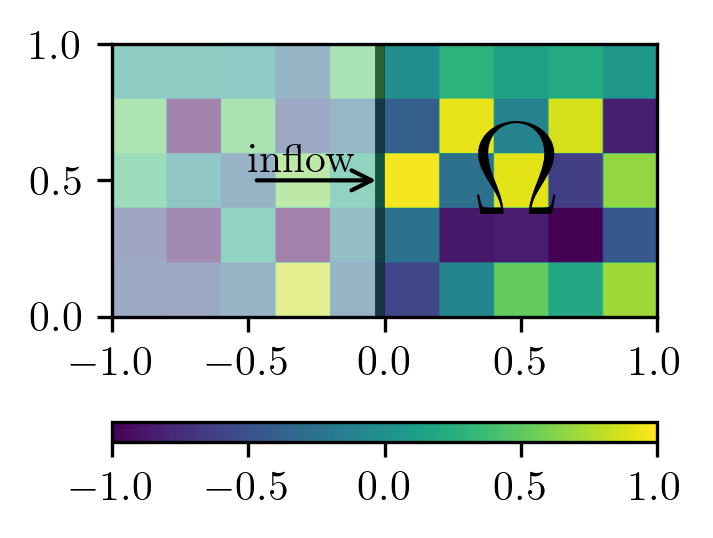

-0.9 0.1
-0.4638432622493358
-0.4638432622493358


In [8]:
f = make_random_IC_2D(nx=s*2, ny=s)

## k- fold convolution, SVD and error computation

In [9]:
p = 2

print(f.shape)
d_Ns = {}
delta_Ns = {}
f_convolved = {}

w = np.int32(m1/s)
h = np.int32(m2/s)
print(w, h)
print(f.shape)
kernel = np.ones((h, w), dtype=np.float64) / (w*h)

m_p, n_p = 5*h, 5*w
f_convolved[0] = np.zeros((m1+2*m_p, 2*m2+2*n_p))
f_convolved[0][m_p:-m_p, n_p:-n_p] = f.copy()


for k in range(5):
    t0 = tmr()
    fk = f_convolved[k][m_p:-m_p, n_p:-n_p].copy()
    Xk = np.zeros((m1*m2, n))
    for j in range(n):
        Xk[:, j] = fk[:, (m2-j):(m2-j+m2)].ravel()
    t1 = tmr()
    print("snapshot matrix made", t1-t0)

    svd_basis = SVD(Xk)
    t2 = tmr()
    print("SVD'ed", t2-t1)

    delta_n, d_n = svd_basis.calc_error()
    d_Ns[k] = d_n
    delta_Ns[k] = delta_n
    t3 = tmr()
    print("error calculated", t3-t2)

    f_convolved[k+1] = convolve(f_convolved[k], kernel, 'same')
    _fk_ = f_convolved[k+1]
    t4 = tmr()
    print("convolved", t4-t3)

(750, 1500)
150 150
(750, 1500)
snapshot matrix made 13.498132977634668
SVD'ed 190.67415932007134
error calculated 0.0002626311033964157
convolved 0.6729376930743456
snapshot matrix made 10.974693043157458
SVD'ed 148.66541408747435
error calculated 0.00028994306921958923
convolved 0.5550149530172348
snapshot matrix made 8.791201071813703
SVD'ed 138.64493273571134
error calculated 0.0005606338381767273
convolved 0.560849666595459
snapshot matrix made 7.816913554444909
SVD'ed 123.6190671492368
error calculated 0.0003614332526922226
convolved 0.6248327251523733
snapshot matrix made 9.076980823650956
SVD'ed 115.04995652474463
error calculated 0.00025544315576553345
convolved 0.5897512137889862


## Fig. 7 (b) Kolmorogov N -width for $C^k(\Omega_P)$-conditions, k = 0, ..., 3.

1.3376712894852456
5.712936175543426
31.92801340954459
202.94658773872644
1422.7066150954615


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


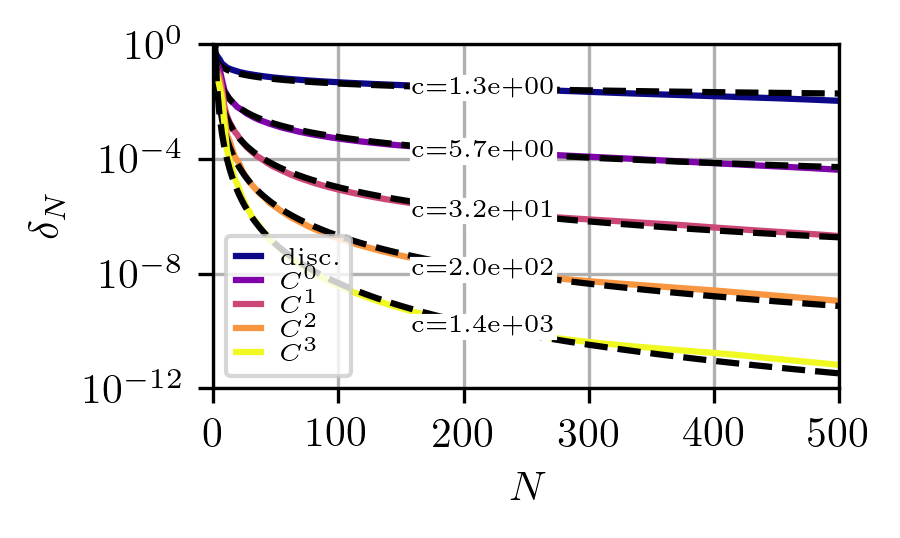

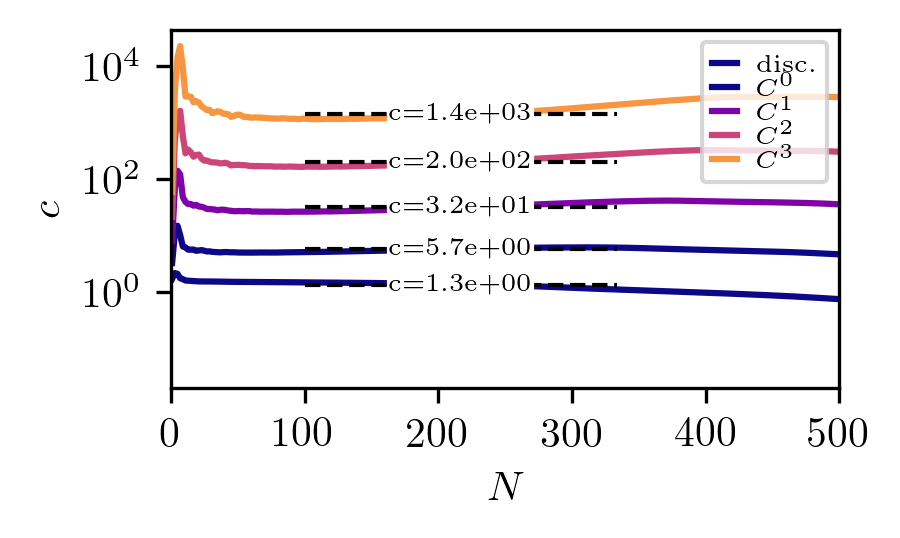

In [10]:
p = 2
    
fig_dN, ax_dN = plt.subplots(tight_layout=True)
fig_d_est, ax_d_est = plt.subplots(tight_layout=True)

for k in range(5):
    if k == 0:
        lbl = "disc."
    else:
        lbl = "$C^{:.0f}$".format(k-1)
    d_n = d_Ns[k]
    delta_n = delta_Ns[k]

    N = np.arange(len(delta_n))+1
    ax_dN.plot(N[::p], delta_n[::p], "-", color=cmap(k/4), label=lbl)
    
    k = k-1
    model = 1/np.pi**(k+2) * N**(-(2*k+3)/2)
    C = delta_n/model
    C_estimated = np.mean(C[100: r//3*2])
    print(C_estimated)
    #ax.plot(N, C_estimated*model, "k--", lw=1, ms=0)

    ax_d_est.plot(N[::p], C[::p], "-", color=cmap(k/4), label=lbl)
    ax_d_est.plot([100, r/3*2], [C_estimated, C_estimated], "k--", lw=1)
    ltex = ax_d_est.text(r/3+50, C_estimated, "c={:.1e}".format(C_estimated), size=6, color="k",
                         ha="center", va="center", bbox=dict(ec='1',fc='1', pad=0))
    ax_dN.plot(N[::p], model[::p]*C_estimated, "k--")
    ltex = ax_dN.text(r//3+50, model[r//3+50]*C_estimated, "c={:.1e}".format(C_estimated), size=6, color="k",
                         ha="center", va="center", bbox=dict(ec='1',fc='1', pad=0))

ax_dN.set_ylim([1e-12, 1e+0])
ax_dN.set_xlim([0, r]) 
ax_dN.set_yscale('log')
ax_dN.legend()
ax_dN.set_xlabel(r'$N$')
ax_dN.set_ylabel(r'$\delta_N$')
ax_dN.grid(which="both")


plt.tight_layout()

ax_d_est.legend()
ax_d_est.set_yscale('log')
ax_d_est.set_xlim([0, r])
#ax_d_est.set_ylim([0, 10])
ax_d_est.set_xlabel(r'$N$')
ax_d_est.set_ylabel(r'$c$')

fig_dN.savefig(pth+"random_2D_decay.pdf")

plt.show()

In [11]:
N = np.arange(r)
for i in range(4):
    fig, ax = plt.subplots()
    plt.plot(N, (delta_Ns[i]/delta_Ns[i+1])[N])
    #plt.xlim(0, 750)
    #plt.ylim(0, 25)
    plt.ylabel("dN_{:.0f}/dN_{:.0f}".format(i, i+1))
    plt.show()


RuntimeError: latex was not able to process the following string:
b'dN_0/dN_1'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/florianma@ad.ife.no/.cache/matplotlib/tex.cache/6a84da8a7c2c39af015d12ad
d2feba5a.tex
LaTeX2e <2017-04-15>
Babel <3.17> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(./6a84da8a7c2c39af015d12add2feba5a.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily dN_
                   0/dN_1}
No pages of output.
Transcript written on 6a84da8a7c2c39af015d12add2feba5a.log.




<Figure size 948.493x586.201 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'dN_1/dN_2'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/florianma@ad.ife.no/.cache/matplotlib/tex.cache/501df894d9fd72771753c043
bfd04885.tex
LaTeX2e <2017-04-15>
Babel <3.17> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(./501df894d9fd72771753c043bfd04885.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily dN_
                   1/dN_2}
No pages of output.
Transcript written on 501df894d9fd72771753c043bfd04885.log.




<Figure size 948.493x586.201 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'dN_2/dN_3'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/florianma@ad.ife.no/.cache/matplotlib/tex.cache/4cbfbce6980c70906e1ec2fd
909da0bf.tex
LaTeX2e <2017-04-15>
Babel <3.17> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(./4cbfbce6980c70906e1ec2fd909da0bf.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily dN_
                   2/dN_3}
No pages of output.
Transcript written on 4cbfbce6980c70906e1ec2fd909da0bf.log.




<Figure size 948.493x586.201 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'dN_3/dN_4'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/florianma@ad.ife.no/.cache/matplotlib/tex.cache/acb30d500363fe1d5359bc4a
97d74200.tex
LaTeX2e <2017-04-15>
Babel <3.17> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(./acb30d500363fe1d5359bc4a97d74200.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily dN_
                   3/dN_4}
No pages of output.
Transcript written on acb30d500363fe1d5359bc4a97d74200.log.




<Figure size 948.493x586.201 with 1 Axes>